In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *


In [2]:
# Create Spark session 
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName('Milestone_I') \
    .getOrCreate()

sc = spark.sparkContext

23/06/13 08:25:26 WARN Utils: Your hostname, MBP.local resolves to a loopback address: 127.0.0.1; using 192.168.0.29 instead (on interface en0)
23/06/13 08:25:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/13 08:25:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Load Data
Load and take a look at the cleaned data (4,585,331 rows):

In [3]:
df = spark.read.parquet("electronics_cleaned.parquet")
df.show()

+----------+-------+--------------+--------------+--------------------+-------------+--------------------+-----+--------------------+-----+----+
|      asin|overall|unixReviewTime|    reviewerID|          reviewText|        brand|            main_cat|price|               title|month|year|
+----------+-------+--------------+--------------+--------------------+-------------+--------------------+-----+--------------------+-----+----+
|1935009354|    5.0|    2016-09-26|A1I4L5LK9BFWO0|Works really grea...|Mighty Bright|         Amazon Home|11.99|Mighty Bright 426...|    9|2016|
|B006PHFGP6|    5.0|    2016-04-19|A1PLZ5PND29KNJ|Worked just great...|       Visico|      Camera & Photo| 8.95|2 x Visico 110v 2...|    4|2016|
|1935009354|    1.0|    2016-09-15|A3Q9HY0LU7MN6E|Right out the pac...|Mighty Bright|         Amazon Home|11.99|Mighty Bright 426...|    9|2016|
|B006QQKII6|    3.0|    2016-07-01|A2DJOAED6QFO88|OK, feels cheap a...|  Simply type|Health & Personal...| 2.54|Hebrew &amp; Engl.

## Overview of Dataset

Schema, columns & datatypes of the data set:

In [4]:
df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- overall: float (nullable = true)
 |-- unixReviewTime: date (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- main_cat: string (nullable = true)
 |-- price: double (nullable = true)
 |-- title: string (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)



Check partitions:

In [5]:
df.rdd.getNumPartitions()

26

## Yearly Summary

Summarize the data by year:

In [6]:
df_agg = df.groupBy('year')\
    .agg(count("year").alias("num_reviews"), \
         countDistinct("reviewerID").alias("num_customers"), \
         floor(sum("price")).alias("total$"), \
         round(mean("price"),2).alias("mean"), \
         min('price').alias('min'), \
         expr('percentile(price, array(0.25))')[0].alias('%25'), \
         expr('percentile(price, array(0.5))')[0].alias('%50'), \
         expr('percentile(price, array(0.75))')[0].alias('%75'), \
         max("price").alias("max"), \
         mode("brand").alias("top_brand"), \
         mode("main_cat").alias("top_category") \
     ) \
    .orderBy('year')

df_agg.show(truncate=False)
    

+----+-----------+-------------+--------+-----+----+-----+-----+-----+--------+------------+---------------+
|year|num_reviews|num_customers|total$  |mean |min |%25  |%50  |%75  |max     |top_brand   |top_category   |
+----+-----------+-------------+--------+-----+----+-----+-----+-----+--------+------------+---------------+
|1999|65         |32           |1347    |20.73|1.54|4.99 |25.9 |27.15|106.9   |Nikon       |All Electronics|
|2000|595        |238          |12513   |21.03|1.54|2.46 |6.7  |25.9 |259.99  |Linksys     |All Electronics|
|2001|1055       |438          |32970   |31.25|1.54|3.83 |15.9 |28.1 |549.99  |Linksys     |All Electronics|
|2002|1679       |688          |48750   |29.07|1.54|2.69 |14.99|29.96|1999.99 |Linksys     |All Electronics|
|2003|2792       |1075         |88354   |31.67|1.54|2.005|9.0  |25.0 |899.95  |Linksys     |All Electronics|
|2004|4303       |1711         |154821  |35.98|0.37|2.78 |12.48|39.99|798.0   |Linksys     |All Electronics|
|2005|6837       |3

*Note: Calculating std was causing the execution to take very long > 10 mins.*

## Visualize totals and median sales

Number of reviews by year:

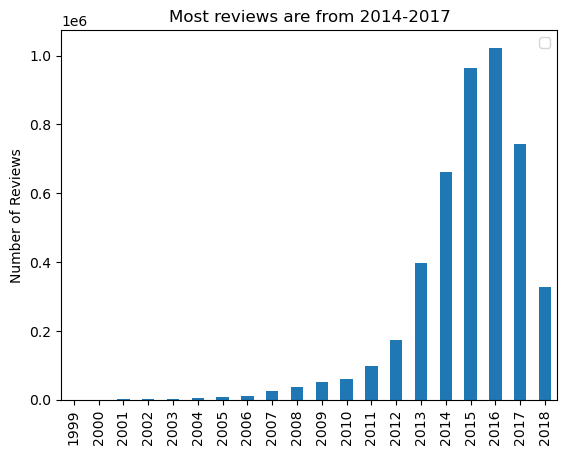

In [7]:
num_reviews = df_agg.select('year', 'num_reviews').toPandas().set_index('year')
num_reviews.plot(kind='bar')
plt.ylabel('Number of Reviews')
plt.xlabel('')
plt.title('Most reviews are from 2014-2017')
plt.legend('')
plt.show()

Number of reviewers by year:

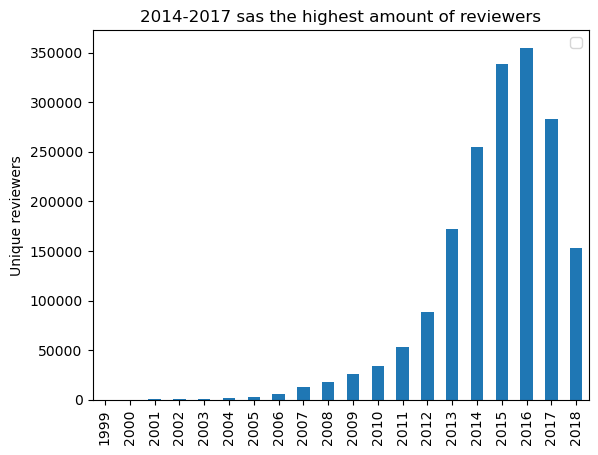

In [8]:
num_reviews = df_agg.select('year', 'num_customers').toPandas().set_index('year')
num_reviews.plot(kind='bar')
plt.ylabel('Unique reviewers')
plt.xlabel('')
plt.title('2014-2017 sas the highest amount of reviewers')
plt.legend('')
plt.show()

Total $ by year:

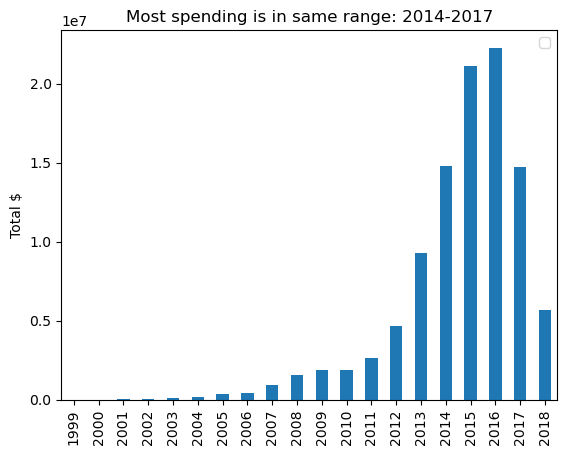

In [9]:
num_reviews = df_agg.select('year', 'total$').toPandas().set_index('year')
num_reviews.plot(kind='bar')
plt.ylabel('Total $')
plt.xlabel('')
plt.title('Most spending is in same range: 2014-2017')
plt.legend('')
plt.show()

Median spending:

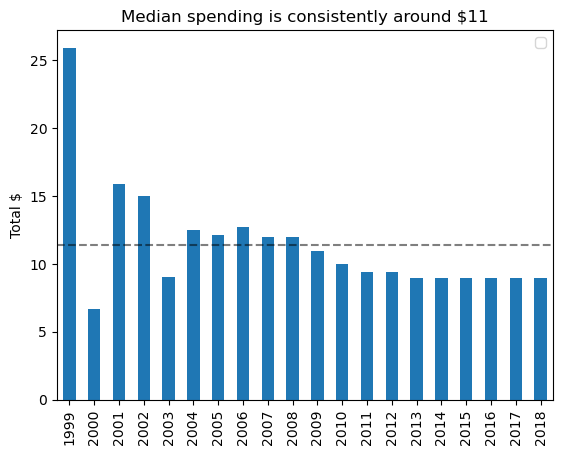

In [10]:
num_reviews = df_agg.select('year', '%50').toPandas().set_index('year')
num_reviews.plot(kind='bar')
plt.axhline(num_reviews.mean().values, linestyle = '--', color = 'black', alpha = 0.5)
plt.ylabel('Total $')
plt.xlabel('')
plt.title('Median spending is consistently around $11')
plt.legend('')
plt.show()

## Customer Lifetime Value

[Customer lifetime value](https://www.qualtrics.com/experience-management/customer/how-to-calculate-customer-lifetime-value/) (CLV) helps you to understand how the profitability of a particular customer or customer segment.

CLV can be calculated at a company level (i.e. the average CLV across all your customers), a customer segment level (the CLV of distinct groups within your customer base) or an individual level (the CLV of each individual customer you deal with).

To start off, we will calculate the company-wide CLV. First we must engineer new features as described in the article above:
- Average reviews value
    - Value of reviews / by number of reviews in that period
    - **This is `mean` value in the table above**
- Average review frequency
    - Number of reviews / number of individual reviewers
- Reviewer Value
    - Average reviews frequency multiplied by the average reviews value
- Average customer lifespan
    - Average length of time a customer continues buying
    - This may difficult as the data is based on purchase reviewers and not all purchasers...

Working in pandas, next we calcuate the average review frequency:

In [11]:
# Convert our yearly summary data from a Spark dataframe to a Pandas dataframe
yearly = df_agg.toPandas()
yearly

,year,num_reviews,num_customers,total$,mean,min,%25,%50,%75,max,top_brand,top_category
0,1999,65,32,1347,20.73,1.54,4.990,25.90,27.15,106.90,Nikon,All Electronics
1,2000,595,238,12513,21.03,1.54,2.460,6.70,25.90,259.99,Linksys,All Electronics
2,2001,1055,438,32970,31.25,1.54,3.830,15.90,28.10,549.99,Linksys,All Electronics
3,2002,1679,688,48750,29.07,1.54,2.690,14.99,29.96,1999.99,Linksys,All Electronics
4,2003,2792,1075,88354,31.67,1.54,2.005,9.00,25.00,899.95,Linksys,All Electronics
5,2004,4303,1711,154821,35.98,0.37,2.780,12.48,39.99,798.00,Linksys,All Electronics
6,2005,6837,3198,361747,53.03,0.37,3.760,12.12,45.12,9599.95,Canon,All Electronics
7,2006,10520,5535,418606,39.80,0.01,4.240,12.74,38.89,9599.95,Canon,All Electronics
8,2007,24139,13063,908392,37.69,0.01,4.980,11.99,35.95,9599.95,Canon,All Electronics
9,2008,36869,18284,1536533,41.71,0.01,5.450,11.99,39.15,9699.99,Canon,All Electronics


### Average review frequency
- Number of reviews / number of individual reviewers

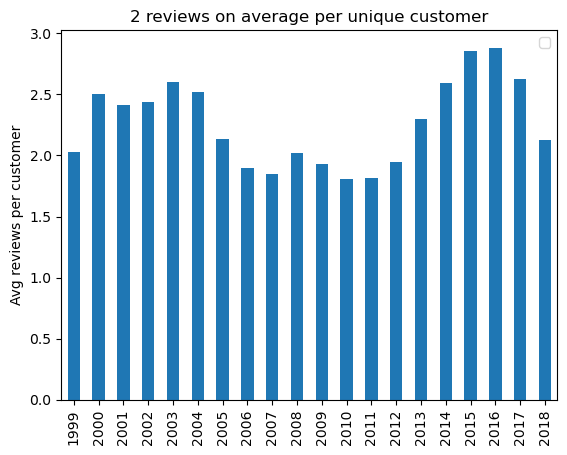

In [12]:
yearly['avg_rev_freq'] = yearly['num_reviews']/yearly['num_customers']
yearly.plot(x = 'year', y = 'avg_rev_freq', kind = 'bar')
plt.ylabel('Avg reviews per customer')
plt.xlabel('')
plt.title('2 reviews on average per unique customer')
plt.legend('')
plt.show()

There are an average of 2 reviews per unique customer in this dataset.

### Reviewer Value
- Average reviews frequency multiplied by the average reviews value (mean)

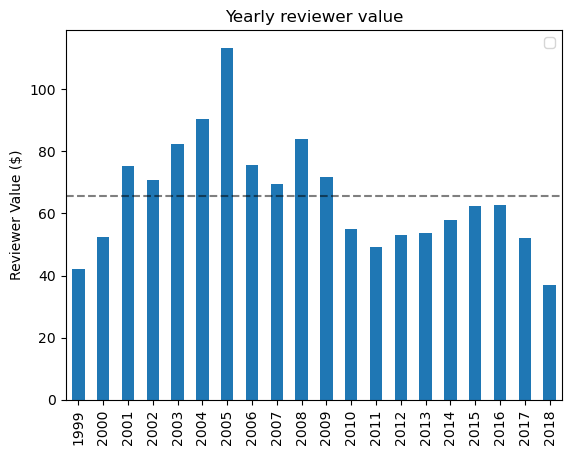

In [13]:
yearly['reviewer_value'] = yearly['avg_rev_freq']*yearly['mean']
yearly.plot(x = 'year', y = 'reviewer_value', kind = 'bar')
plt.axhline(yearly['reviewer_value'].mean(),linestyle = '--', color = 'black', alpha = 0.5)
plt.ylabel('Reviewer Value ($)')
plt.xlabel('')
plt.title('Yearly reviewer value')
plt.legend('')
plt.show()

Average reviewer value is around $65, and was highest in 2005 and lowest in 2018. *Highlight mean, high, low, on plot*

### Average customer lifespan (Average reviewer activity)
- Average length of time a customer continues buying
- For this analysis we will determine the average number of yearly reviews per reviewer.

First, for each reviewer how many reviews were left each year? Then will find the average per year.

In [14]:
# Calculate the number of avg months each reviewer left a review, per year
# reviewer_lifespan = df.groupBy('reviewerID', 'year') \
#     .agg(countDistinct('month').alias('num_months')) \
#     .groupBy('year') \
#         .agg(round(mean('num_months'),2).alias('avg_num_months')) \
#         .orderBy('year').toPandas()

# reviewer_lifespan

In [15]:
# Calculate the number of reviews each reviewer left each year
reviewer_lifespan = df.groupBy('reviewerID', 'year') \
    .agg(countDistinct('reviewText').alias('num_reviews')) \
    .groupBy('year') \
        .agg(round(mean('num_reviews'),2).alias('avg_reviews_per_reviewer')) \
        .orderBy('year').toPandas()

reviewer_lifespan

23/06/13 08:27:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/06/13 08:27:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/06/13 08:27:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/06/13 08:27:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/06/13 08:27:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/06/13 08:27:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/06/13 08:27:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/06/13 08:27:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/06/13 08:27:11 WARN RowBasedKeyValueBatch: Calling spill() on

,year,avg_reviews_per_reviewer
0,1999,1.03
1,2000,1.24
2,2001,1.20
3,2002,1.20
4,2003,1.29
5,2004,1.26
6,2005,1.22
7,2006,1.25
8,2007,1.32
9,2008,1.35


In [16]:
# Add to main dataframe
yearly = yearly.merge(reviewer_lifespan, on = 'year')

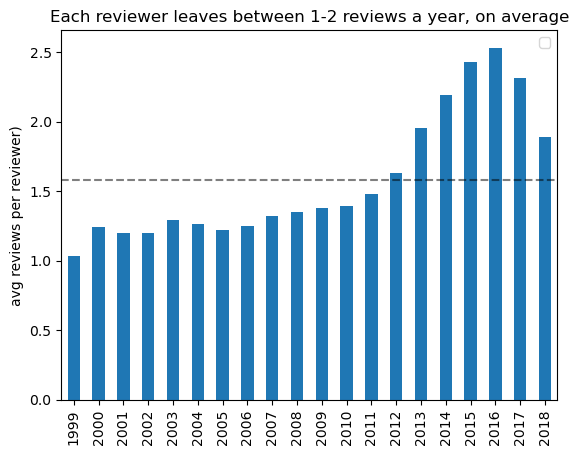

In [17]:
yearly.plot(x = 'year', y = 'avg_reviews_per_reviewer', kind = 'bar')
plt.axhline(yearly['avg_reviews_per_reviewer'].mean(),linestyle = '--', color = 'black', alpha = 0.5)
plt.ylabel('avg reviews per reviewer)')
plt.xlabel('')
plt.title('Each reviewer leaves between 1-2 reviews a year, on average')
plt.legend('')
plt.show()

### Customer lifetime value = (customer value * average customer lifespan)

For the data I'll calculate reviewer lifetime value = reviewer value * average yearly reviews

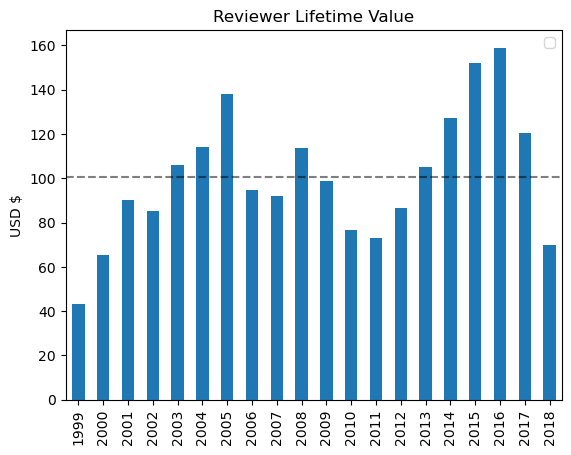

In [18]:
yearly['reviewer_lifetime_value'] = yearly['reviewer_value']*yearly['avg_reviews_per_reviewer']
yearly.plot(x = 'year', y = 'reviewer_lifetime_value', kind = 'bar')
plt.axhline(yearly['reviewer_lifetime_value'].mean(),linestyle = '--', color = 'black', alpha = 0.5)
plt.ylabel('USD $')
plt.xlabel('')
plt.title('Reviewer Lifetime Value')
plt.legend('')
plt.show()

## By month across years

In [111]:
monthly = df.groupBy('year', 'month') \
.agg(count('*').alias('num_reviews'),
     sum('price').alias('total_$')) \
.orderBy('year', 'month') \
.toPandas()

monthly

,year,month,num_reviews,total_$
0,1999,7,4,121.26
1,1999,8,4,74.58
2,1999,9,3,65.61
3,1999,10,8,189.98
4,1999,11,10,179.22
...,...,...,...,...
227,2018,6,33061,584492.72
228,2018,7,26027,454831.46
229,2018,8,13681,255890.65
230,2018,9,4232,85321.41


Pivot the data:

In [117]:
reviews_pivot = monthly.pivot(columns = 'month', index = 'year')['num_reviews']
reviews_pivot

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
1999,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,3.0,8.0,10.0,36.0
2000,18.0,16.0,14.0,32.0,65.0,62.0,40.0,44.0,63.0,86.0,71.0,84.0
2001,56.0,89.0,55.0,74.0,76.0,98.0,86.0,88.0,75.0,92.0,104.0,162.0
2002,111.0,110.0,162.0,78.0,112.0,105.0,130.0,122.0,141.0,192.0,194.0,222.0
2003,275.0,194.0,201.0,199.0,223.0,250.0,224.0,222.0,213.0,204.0,277.0,310.0
2004,322.0,267.0,299.0,274.0,269.0,268.0,287.0,342.0,402.0,462.0,465.0,646.0
2005,632.0,440.0,531.0,397.0,411.0,399.0,543.0,748.0,796.0,736.0,513.0,691.0
2006,897.0,847.0,1043.0,591.0,574.0,717.0,985.0,1051.0,644.0,612.0,1408.0,1151.0
2007,3071.0,1634.0,2057.0,1374.0,2242.0,1556.0,1838.0,1776.0,1822.0,1874.0,2180.0,2715.0


In [172]:
reviews_pivot.describe()

month,1,2,3,4,5,6,7,8,9,10,11,12
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,20.000000,20.000000,20.000000,20.000000,19.000000,19.000000
mean,24803.210526,21104.526316,21904.684211,19592.473684,18925.578947,18053.210526,19114.700000,18765.300000,17174.600000,17111.200000,18417.368421,22568.157895
std,35801.329729,30952.120070,31801.428841,28198.016558,27451.864906,26315.968221,29221.111854,29511.595092,27627.921865,27655.375493,27778.690380,32856.045294
min,18.000000,16.000000,14.000000,32.000000,65.000000,62.000000,4.000000,4.000000,3.000000,8.000000,10.000000,36.000000
25%,477.000000,353.500000,415.000000,335.500000,340.000000,333.500000,271.250000,312.000000,354.750000,201.000000,371.000000,478.000000
50%,5597.000000,4405.000000,4107.000000,4069.000000,3983.000000,4089.000000,3246.500000,3270.000000,3538.500000,2428.000000,3481.000000,4356.000000
75%,44522.500000,36305.500000,38155.500000,34293.500000,33495.000000,30826.500000,27239.000000,18217.750000,15649.250000,17449.250000,26590.500000,41361.000000
max,101161.000000,89520.000000,88004.000000,79730.000000,84612.000000,81065.000000,87771.000000,87521.000000,81908.000000,79492.000000,80974.000000,91378.000000


Text(0.5, 0, 'num_reviews')

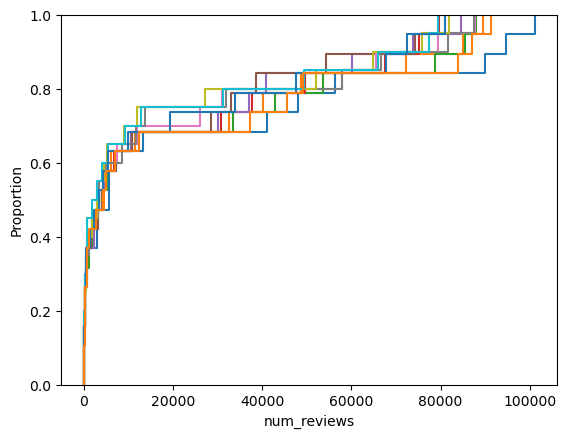

In [192]:
for k in reviews_pivot.keys():
    sns.ecdfplot(reviews_pivot[k].values)

plt.xlabel('num_reviews')

### Total $

In [118]:
total_pivot = monthly.pivot(columns = 'month', index = 'year')['total_$']
total_pivot

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
1999,NaN,NaN,NaN,NaN,NaN,NaN,121.26,74.58,65.61,189.98,179.22,717.08
2000,281.92,230.92,238.76,1117.58,1277.26,1149.82,1028.32,619.06,1117.89,2419.36,1186.27,1846.06
2001,1674.66,2290.80,1212.23,3792.62,2038.84,3526.42,2410.56,2494.34,3394.50,1641.94,3080.22,5413.47
2002,2412.22,2945.60,4363.38,1530.14,3454.68,2862.56,3346.50,3101.70,3928.56,3497.26,6311.96,10996.36
2003,7406.12,7385.68,4170.34,6170.47,7336.60,7038.60,8711.38,4971.10,5405.52,7384.34,10517.79,11856.41
2004,9510.82,6788.80,10401.44,9553.52,9879.08,8214.82,9429.14,11079.69,14032.93,16158.55,19888.32,29884.63
2005,27477.19,16359.77,28807.24,21462.31,15764.09,22520.76,28010.12,48641.62,48044.61,52927.15,20785.34,30947.00
2006,34085.48,26640.57,37104.26,27424.05,25695.63,25243.78,39449.02,32863.63,26819.22,26975.86,45581.53,70723.41
2007,108080.99,56635.65,65426.88,45873.27,75099.98,57694.82,71062.28,68441.22,75126.16,72240.35,103460.30,109250.38


In [136]:
total_pivot.describe()

month,1,2,3,4,5,6,7,8,9,10,11,12
count,1.900000e+01,1.900000e+01,1.900000e+01,1.900000e+01,1.900000e+01,1.900000e+01,2.000000e+01,2.000000e+01,2.000000e+01,2.000000e+01,1.900000e+01,1.900000e+01
mean,5.471567e+05,4.658173e+05,4.816269e+05,4.339276e+05,4.271487e+05,4.063522e+05,4.223894e+05,4.233578e+05,3.844686e+05,3.797684e+05,4.203397e+05,5.172696e+05
std,7.486738e+05,6.523778e+05,6.599066e+05,5.858834e+05,5.924793e+05,5.638304e+05,6.175147e+05,6.386161e+05,5.793153e+05,5.791320e+05,5.911195e+05,7.117158e+05
min,2.819200e+02,2.309200e+02,2.387600e+02,1.117580e+03,1.277260e+03,1.149820e+03,1.212600e+02,7.458000e+01,6.561000e+01,6.040000e+01,1.792200e+02,7.170800e+02
25%,1.849400e+04,1.187272e+04,1.960434e+04,1.550792e+04,1.282158e+04,1.536779e+04,9.249700e+03,9.552542e+03,1.187608e+04,6.412570e+03,1.520305e+04,2.087052e+04
50%,1.935816e+05,1.555725e+05,1.687728e+05,1.376897e+05,1.370215e+05,1.328138e+05,1.316818e+05,1.216916e+05,1.009836e+05,1.012251e+05,1.464639e+05,1.804323e+05
75%,9.445178e+05,7.835711e+05,8.313459e+05,7.712502e+05,7.032118e+05,6.287607e+05,5.291701e+05,4.147906e+05,4.430355e+05,4.325888e+05,6.401521e+05,8.928601e+05
max,2.209807e+06,1.951475e+06,1.885232e+06,1.749425e+06,1.901082e+06,1.770814e+06,1.902683e+06,1.932623e+06,1.753265e+06,1.740997e+06,1.728977e+06,1.960883e+06


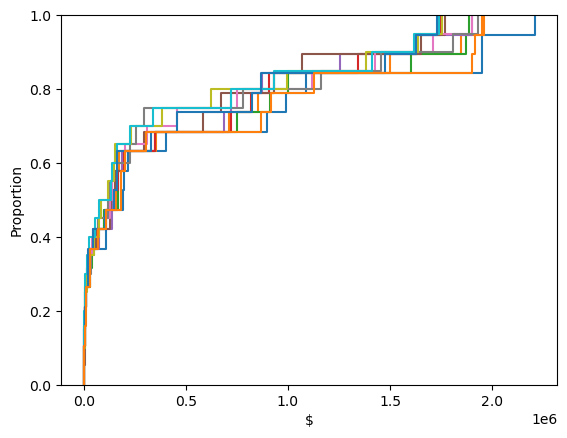

In [195]:
for k in total_pivot.keys():
    sns.ecdfplot(total_pivot[k].values)
plt.xlabel('$')
plt.show()

<Axes: xlabel='year'>

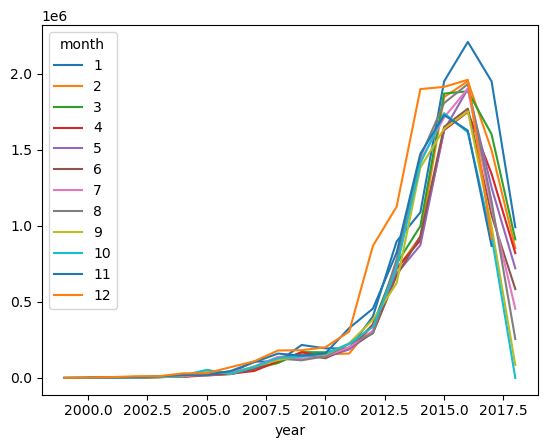

In [196]:
total_pivot.plot()

#### Plots

In [197]:
yearlist = list(monthly.groupby('year').groups.keys())
# monthly.groupby('year').get_group(yearlist[1])

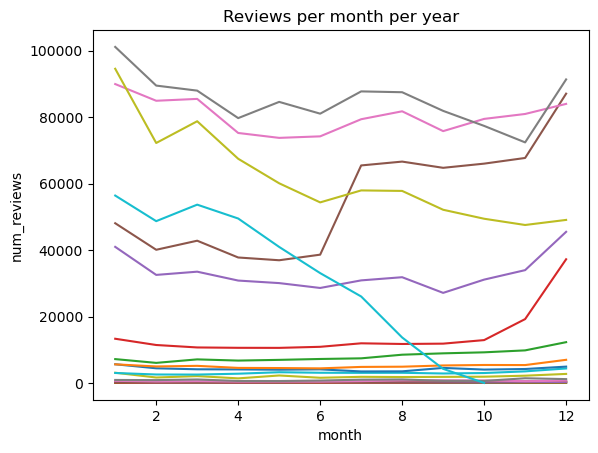

In [204]:
for year in yearlist:
    curr_year = monthly.groupby('year').get_group(year)
    plt.plot(curr_year['month'], curr_year['num_reviews'])

plt.ylabel('num_reviews')
plt.xlabel('month')
plt.title("Reviews per month per year")
plt.show()
